# Case Study: CNN Transfer Learning



# UC Merced Dataset

### Context:
UC Merced is a 21 class land use remote sensing image dataset, with 100 images per class. The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. While most images are 256x256 pixels, there are 44 images with different shape.

### Objective:
The goal is to build a robust Deep learning model that is able to distinguish between different classes of the remote sensing image dataset.


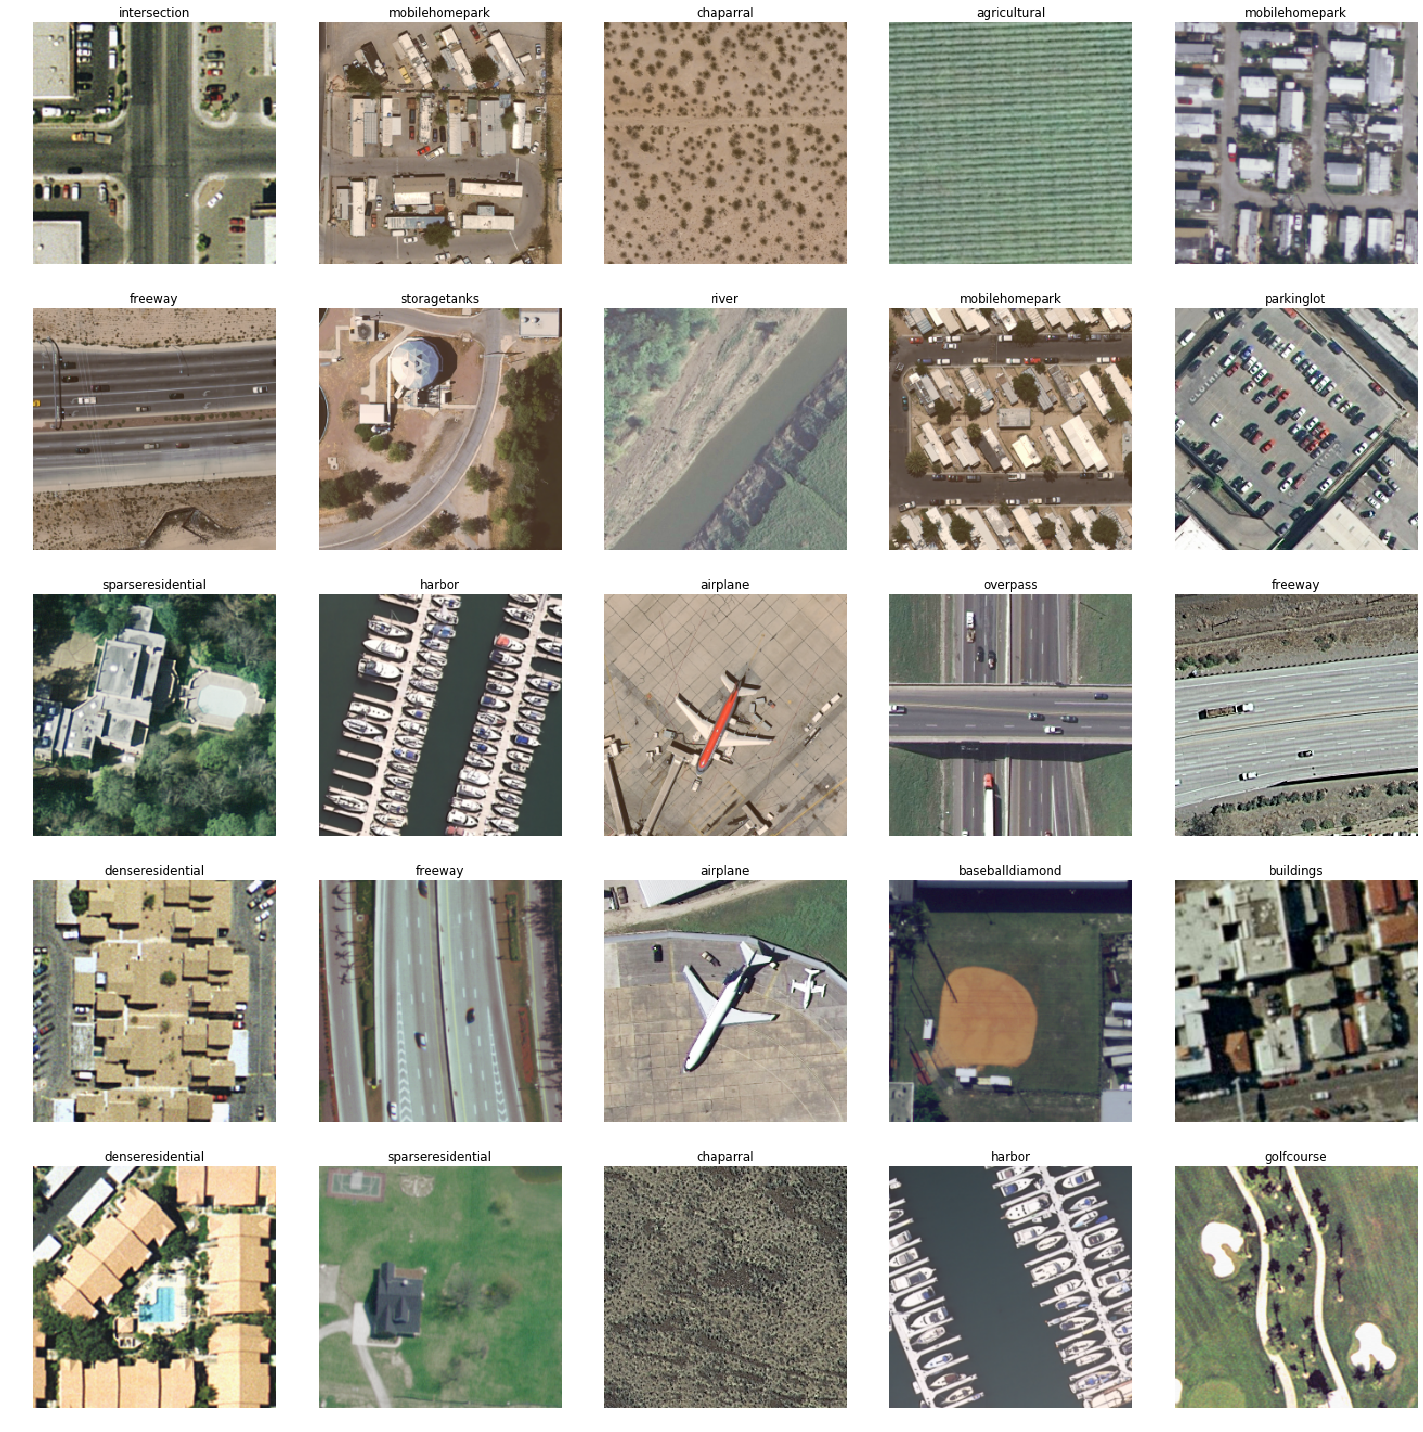

### Dataset Source: https://www.tensorflow.org/datasets/catalog/uc_merced

In [ ]:
# Import required libraries

# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
tensorflow.__version__

'2.11.0'

In [ ]:
## Mount your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Set the appropriate path for the datsaet zip provided**

In [ ]:
images_path = "/content/drive/MyDrive/Datasets/Dataset.zip"

**Extracting the dataset.zip to the present working directory**

In [ ]:
from zipfile import ZipFile
with ZipFile(images_path, 'r') as z:
  z.extractall()

NameError: ignored

*Check the list of files in the pwd(present working directory) by running command 'ls' and ensure 'dataset' folder has been generated*

In [ ]:
!ls

Dataset  drive	sample_data


### Data Extraction and Visualization

In [ ]:
# Extracting the images and storing it in a dataframe
import os
import cv2

file_path = '/content/Dataset/Images'
df = pd.DataFrame(columns=['file_name','class','image'])
for i in os.listdir(file_path):
    if i != '.DS_Store': #This if condition is machine specific - can be ignored
        for j in os.listdir(os.path.join(file_path,i)):
            img = cv2.imread(os.path.join(file_path,i,j))
            df = df.append({'file_name':j,'class':i,'image':img},ignore_index=True)

In [ ]:
df['class'].unique() # Target Classes

array(['buildings', 'beach', 'baseballdiamond', 'overpass', 'golfcourse',
       'mobilehomepark', 'parkinglot', 'agricultural', 'denseresidential',
       'airplane', 'freeway', 'storagetanks', 'intersection', 'river',
       'runway', 'chaparral', 'forest', 'tenniscourt',
       'sparseresidential', 'mediumresidential', 'harbor'], dtype=object)

In [ ]:
# Checking the dataframe
df.head()

file_name      class  \
0  buildings43.tif  buildings   
1  buildings89.tif  buildings   
2  buildings61.tif  buildings   
3  buildings00.tif  buildings   
4  buildings26.tif  buildings   

                                               image  
0  [[[76, 86, 93], [76, 77, 86], [57, 52, 61], [5...  
1  [[[131, 139, 153], [131, 139, 152], [133, 141,...  
2  [[[202, 204, 201], [204, 207, 205], [203, 207,...  
3  [[[213, 225, 213], [213, 224, 215], [213, 224,...  
4  [[[167, 188, 185], [168, 194, 188], [153, 180,...

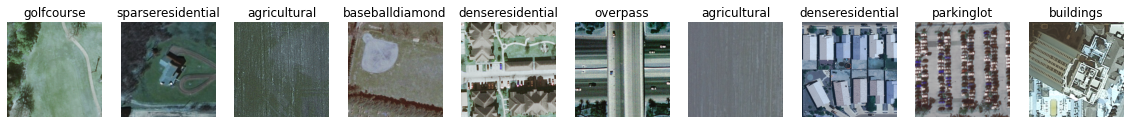

In [ ]:
# visualizing the random images in the dataset along with their labels
def sample_img(df,n):
    df = df.sample(n)
    plt.figure(figsize=(20,20))
    for i,j in enumerate(df.iterrows()):
        plt.subplot(1,n,i+1)
        plt.imshow(j[1]['image'])
        plt.title("{}".format(j[1]['class']))
        plt.axis('off')
sample_img(df,10)

### Data Preparation

In [ ]:
## Segregate X and Y

X = df['image']
y = df['class']

In [ ]:
## Split the dataset into train and test

from sklearn.model_selection import train_test_split

X_tr, X_te, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

print("Training:",X_tr.shape, y_train.shape)
print('Testing:',X_te.shape,y_test.shape)

Training: (1470,) (1470,)
Testing: (630,) (630,)


In [ ]:
# Reshaping X_train and X_test suitable for the model

import cv2
X_train = []
for i, j in enumerate(X_tr):
    img = cv2.resize(j, (128, 128))
    X_train.append(img)

X_test = []
for i, j in enumerate(X_te):
    img = cv2.resize(j, (128, 128))
    X_test.append(img)

# Convert to Numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Lets check the shape after reshaping
print('Train data:', X_train.shape)
print('Test data:', X_test.shape)

Train data: (1470, 128, 128, 3)
Test data: (630, 128, 128, 3)


In [ ]:
# Normalizing the X_train and X_test

X_train = (X_train/255).astype('float32')
X_test = (X_test/255).astype('float32')

In [ ]:
# Lets check the max and min values

print("Max and Min value in X_train:", X_train.max(), X_train.min())
print("Max and Min value in X_test:", X_test.max(), X_test.min())

Max and Min value in X_train: 1.0 0.0
Max and Min value in X_test: 1.0 0.0


In [ ]:
# Convert your target feature to one-hot vectors

y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)


print("Shape of y_train:", y_train_onehot.shape)
print("One value of y_train:", y_train_onehot)

Shape of y_train: (1470, 21)
One value of y_train:       agricultural  airplane  baseballdiamond  beach  buildings  chaparral  \
1056             0         0                0      0          0          0   
946              0         1                0      0          0          0   
672              0         0                0      0          0          0   
378              0         0                0      0          0          0   
717              1         0                0      0          0          0   
...            ...       ...              ...    ...        ...        ...   
1033             0         0                0      0          0          0   
1731             0         0                0      0          0          0   
763              1         0                0      0          0          0   
835              0         0                0      0          0          0   
1653             0         0                0      0          0          0   

      denser

### Basic CNN model

In [ ]:
# Initializing basic CNN model

from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.models import Sequential


model = Sequential()
model.add(Conv2D(filters=224, kernel_size=3, activation="relu", input_shape=(128, 128, 3)))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(21, activation="softmax"))


# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 224)     6272      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 128)     258176    
                                                                 
 conv2d_2 (Conv2D)           (None, 122, 122, 64)      73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 32)      18464     
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 64)                29491264  
                                                                 
 dense_1 (Dense)             (None, 128)               8

In [ ]:
basic_cnn_history = model.fit(x=X_train, y=y_train_onehot,
                             batch_size=32,
                             epochs=50,
                             validation_data=(X_test, y_test_onehot))

Epoch 1/50
46/46 [==============================] - 30s 316ms/step - loss: 3.2451 - accuracy: 0.0490 - val_loss: 3.0449 - val_accuracy: 0.0397
Epoch 2/50
46/46 [==============================] - 10s 219ms/step - loss: 3.0443 - accuracy: 0.0429 - val_loss: 3.0367 - val_accuracy: 0.0397
Epoch 3/50
46/46 [==============================] - 10s 219ms/step - loss: 3.0429 - accuracy: 0.0483 - val_loss: 3.0459 - val_accuracy: 0.0381
Epoch 4/50
46/46 [==============================] - 10s 220ms/step - loss: 3.0443 - accuracy: 0.0517 - val_loss: 3.0466 - val_accuracy: 0.0381
Epoch 5/50
46/46 [==============================] - 10s 222ms/step - loss: 3.0659 - accuracy: 0.0537 - val_loss: 3.0468 - val_accuracy: 0.0381
Epoch 6/50
46/46 [==============================] - 10s 224ms/step - loss: 3.0600 - accuracy: 0.0517 - val_loss: 3.0471 - val_accuracy: 0.0381
Epoch 7/50
46/46 [==============================] - 10s 225ms/step - loss: 3.1061 - accuracy: 0.0449 - val_loss: 3.0477 - val_accuracy: 0.0381

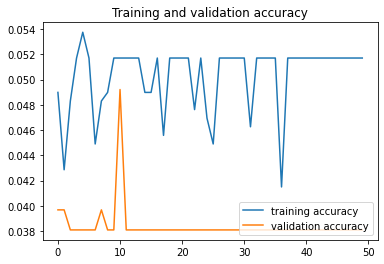

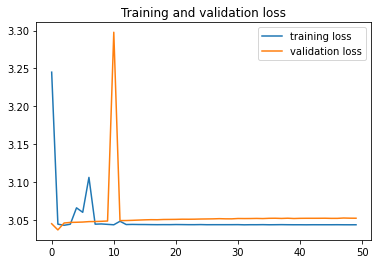

In [ ]:
## Accuracy and Loss plots

accuracy = basic_cnn_history.history['accuracy']
val_accuracy = basic_cnn_history.history['val_accuracy']
loss = basic_cnn_history.history['loss']
val_loss = basic_cnn_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model.save('basic_cnn.h5')
model.save_weights('basiccnn_weights1.h5')

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = VGG16(input_shape=(128,128,3),
                   weights='imagenet',
                   include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x) #dense layer 2
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x) #dense layer 3
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
preds = Dense(21, activation='softmax')(x) #final layer with sigmoid activation

model_vgg16 = Model(inputs=base_model.input, outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg16.layers[:20]:
    layer.trainable=False
for layer in model_vgg16.layers[20:]:
    layer.trainable=True

# Compile the model
model_vgg16.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
vgg16_history = model_vgg16.fit(x=X_train, y=y_train_onehot,
                                batch_size=64,
                                epochs=50,
                               validation_data=(X_test, y_test_onehot))

Epoch 1/50
23/23 [==============================] - 22s 352ms/step - loss: 3.1204 - accuracy: 0.1361 - val_loss: 2.5208 - val_accuracy: 0.3667
Epoch 2/50
23/23 [==============================] - 3s 140ms/step - loss: 2.1075 - accuracy: 0.3578 - val_loss: 2.0765 - val_accuracy: 0.6048
Epoch 3/50
23/23 [==============================] - 3s 139ms/step - loss: 1.5748 - accuracy: 0.4986 - val_loss: 1.7510 - val_accuracy: 0.7159
Epoch 4/50
23/23 [==============================] - 3s 140ms/step - loss: 1.2843 - accuracy: 0.6068 - val_loss: 1.5443 - val_accuracy: 0.7508
Epoch 5/50
23/23 [==============================] - 3s 140ms/step - loss: 1.0844 - accuracy: 0.6510 - val_loss: 1.3570 - val_accuracy: 0.7302
Epoch 6/50
23/23 [==============================] - 3s 141ms/step - loss: 0.9495 - accuracy: 0.6898 - val_loss: 1.2383 - val_accuracy: 0.7667
Epoch 7/50
23/23 [==============================] - 3s 140ms/step - loss: 0.8552 - accuracy: 0.7170 - val_loss: 1.2006 - val_accuracy: 0.7317
Epoch

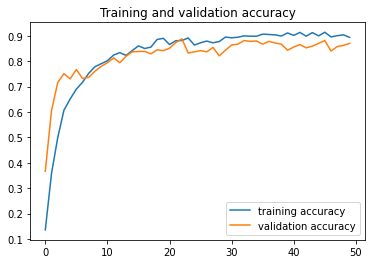

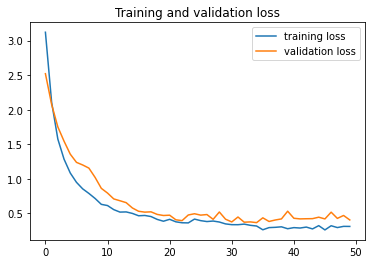

In [ ]:
## Accuracy and Loss plots

accuracy = vgg16_history.history['accuracy']
val_accuracy = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_vgg16.save('vgg16_cnn.h5')
model_vgg16.save_weights('vgg16_weights1.h5')

### VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = VGG19(input_shape=X_train[0].shape,
                   weights='imagenet',
                   include_top=False) #imports the VGG16 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x) #dense layer 2
x = Dense(256, activation='relu')(x) #dense layer 3
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
preds = Dense(21, activation='softmax')(x) #final layer with softmax activation

model_vgg19 = Model(inputs=base_model.input,
                    outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_vgg19.layers[:20]:
    layer.trainable=False
for layer in model_vgg19.layers[20:]:
    layer.trainable=True

# Compile the model
model_vgg19.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

model_vgg19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
vgg19_history = model_vgg19.fit(x=X_train, y=y_train_onehot,
                              batch_size=64,
                              epochs=50,
                              validation_data=(X_test, y_test_onehot))

Epoch 1/50
23/23 [==============================] - 6s 192ms/step - loss: 2.8708 - accuracy: 0.1864 - val_loss: 3.1649 - val_accuracy: 0.1556
Epoch 2/50
23/23 [==============================] - 4s 173ms/step - loss: 1.8338 - accuracy: 0.4245 - val_loss: 1.8540 - val_accuracy: 0.3794
Epoch 3/50
23/23 [==============================] - 4s 174ms/step - loss: 1.3573 - accuracy: 0.5537 - val_loss: 1.2153 - val_accuracy: 0.5730
Epoch 4/50
23/23 [==============================] - 4s 182ms/step - loss: 1.0349 - accuracy: 0.6544 - val_loss: 0.8672 - val_accuracy: 0.7429
Epoch 5/50
23/23 [==============================] - 4s 178ms/step - loss: 0.8948 - accuracy: 0.7116 - val_loss: 0.8073 - val_accuracy: 0.7683
Epoch 6/50
23/23 [==============================] - 4s 183ms/step - loss: 0.7320 - accuracy: 0.7592 - val_loss: 0.6534 - val_accuracy: 0.7921
Epoch 7/50
23/23 [==============================] - 4s 178ms/step - loss: 0.5906 - accuracy: 0.8116 - val_loss: 0.8343 - val_accuracy: 0.7381
Epoch 

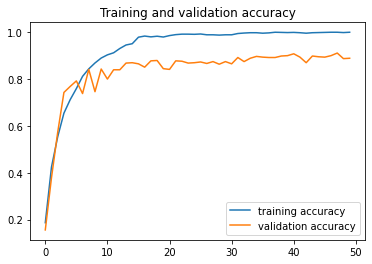

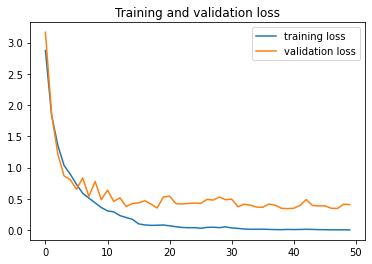

In [ ]:
## Accuracy and Loss plots

accuracy = vgg19_history.history['accuracy']
val_accuracy = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot(epochs, accuracy, label = 'training accuracy')
plt.plot(epochs, val_accuracy, label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot(epochs, loss, label = 'training loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_vgg19.save('vgg19.h5')
model_vgg19.save_weights('vgg19_weights.h5')

### ResNet50

In [ ]:
import tensorflow
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(input_shape=(128, 128 ,3),
                      weights='imagenet',
                      include_top=False) #imports the ResNet50 model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(21, activation='softmax')(x)

model_resnet50 = Model(inputs=base_model.input, outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_resnet50.layers[:150]:
    layer.trainable=False
for layer in model_resnet50.layers[150:]:
    layer.trainable=True

# Compile the model
model_resnet50.compile(optimizer=tensorflow.optimizers.Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

model_resnet50.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

In [ ]:
resent50_history = model_resnet50.fit(x=X_train, y=y_train_onehot,
                                     batch_size=64,
                                     epochs=50,
                                     validation_data=(X_test, y_test_onehot))

Epoch 1/50
23/23 [==============================] - 10s 234ms/step - loss: 3.5253 - accuracy: 0.1082 - val_loss: 3.1042 - val_accuracy: 0.0429
Epoch 2/50
23/23 [==============================] - 3s 114ms/step - loss: 2.7587 - accuracy: 0.2163 - val_loss: 3.0825 - val_accuracy: 0.0603
Epoch 3/50
23/23 [==============================] - 3s 114ms/step - loss: 2.3408 - accuracy: 0.3095 - val_loss: 3.0727 - val_accuracy: 0.0603
Epoch 4/50
23/23 [==============================] - 3s 115ms/step - loss: 2.1030 - accuracy: 0.3612 - val_loss: 3.0925 - val_accuracy: 0.0619
Epoch 5/50
23/23 [==============================] - 3s 115ms/step - loss: 1.8380 - accuracy: 0.4408 - val_loss: 3.1184 - val_accuracy: 0.0492
Epoch 6/50
23/23 [==============================] - 3s 115ms/step - loss: 1.7055 - accuracy: 0.4823 - val_loss: 3.1378 - val_accuracy: 0.0429
Epoch 7/50
23/23 [==============================] - 3s 116ms/step - loss: 1.5690 - accuracy: 0.5347 - val_loss: 3.1368 - val_accuracy: 0.0476
Epoch

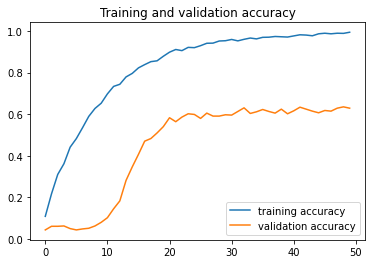

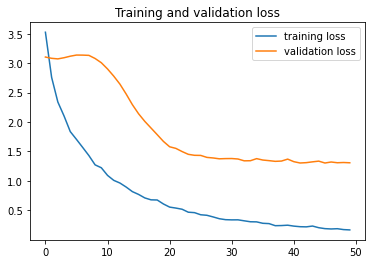

In [ ]:
## Accuracy and Loss plots

accuracy = resent50_history.history['accuracy']
val_accuracy = resent50_history.history['val_accuracy']
loss = resent50_history.history['loss']
val_loss = resent50_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_resnet50.save('resnet50.h5')
model_resnet50.save_weights('resnet50_weights.h5')

### MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNet(input_shape=(128,128,3),
                       weights='imagenet',
                       include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x) #dense layer 2
x = Dense(256,activation='relu')(x) #dense layer 3
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
preds = Dense(21,activation='softmax')(x) #final layer with softmax activation

model_mobilenet = Model(inputs=base_model.input,
                        outputs=preds)

# set the first 20 layers of the network to be non-trainable
for layer in model_mobilenet.layers[:20]:
    layer.trainable=False
for layer in model_mobilenet.layers[20:]:
    layer.trainable=True

# Compile the model
model_mobilenet.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_mobilenet.summary()

17235968/17225924 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128  

In [ ]:
# Model with the non-trainable first 20 layers

mobilenet_history = model_mobilenet.fit(x=X_train, y=y_train_onehot,
                                          batch_size=64,
                                          epochs=100,
                                          validation_data=(X_test, y_test_onehot))

Epoch 1/100
23/23 [==============================] - 7s 158ms/step - loss: 2.0721 - accuracy: 0.4259 - val_loss: 3.4842 - val_accuracy: 0.1937
Epoch 2/100
23/23 [==============================] - 2s 78ms/step - loss: 0.5460 - accuracy: 0.8320 - val_loss: 2.5030 - val_accuracy: 0.4032
Epoch 3/100
23/23 [==============================] - 2s 74ms/step - loss: 0.2529 - accuracy: 0.9163 - val_loss: 1.3532 - val_accuracy: 0.6508
Epoch 4/100
23/23 [==============================] - 2s 73ms/step - loss: 0.1230 - accuracy: 0.9633 - val_loss: 0.9901 - val_accuracy: 0.7333
Epoch 5/100
23/23 [==============================] - 2s 74ms/step - loss: 0.0810 - accuracy: 0.9782 - val_loss: 0.6433 - val_accuracy: 0.8476
Epoch 6/100
23/23 [==============================] - 2s 74ms/step - loss: 0.0516 - accuracy: 0.9830 - val_loss: 0.3998 - val_accuracy: 0.9016
Epoch 7/100
23/23 [==============================] - 2s 76ms/step - loss: 0.0763 - accuracy: 0.9789 - val_loss: 0.2735 - val_accuracy: 0.9349
Epoch

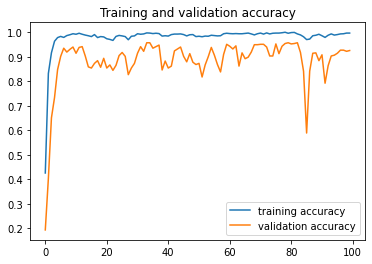

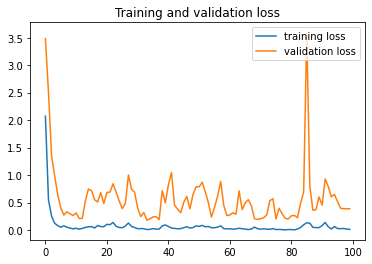

In [ ]:
## Accuracy and Loss plots

accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs   = range(len(accuracy)) # Get number of epochs

plt.plot  (epochs, accuracy, label = 'training accuracy')
plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
plt.title ('Training and validation accuracy')
plt.legend(loc = 'lower right')
plt.figure()

plt.plot  (epochs, loss, label = 'training loss')
plt.plot  (epochs, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')
plt.show()

In [ ]:
# Saving model and its weights for future use
model_mobilenet.save('mobilenet.h5')
model_mobilenet.save_weights('mobilenet_weights.h5')

### From the results we can conclude that VGG16 outperformed all the other models by giving us a balanced results for training and testing above ~85%. So, we can use VGG16 for doing further predictions, which can distinguish between different classes of the remote sensing image dataset.

### Loading the saved VGG16 model and doing the predictions.

In [ ]:
from tensorflow.keras.models import load_model

# Loading VGG16
model_vgg16 = load_model('vgg16_cnn.h5')

------------------------------------------------------------
VGG16
Softmax Outputs: [[6.8644945e-06 1.7505637e-04 2.8061774e-02 2.1646467e-04 1.5420713e-01
  1.3267178e-05 7.3393958e-04 2.1446134e-05 4.4509381e-04 1.2824973e-04
  1.3731485e-05 6.4866627e-03 1.6232065e-03 2.0301240e-04 1.1984732e-03
  1.1591250e-04 1.3241726e-04 9.9198148e-03 4.4824797e-04 2.1470839e-03
  7.9370207e-01]]


Predicted_Label_vgg16: tenniscourt


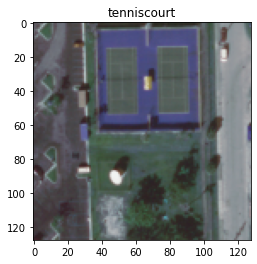

In [ ]:
# Predicting and vizualizing the test image using pretrained Model

import matplotlib.pyplot as plt
%matplotlib inline

n = 60
plt.title(list(y_test)[n])
plt.imshow(list(X_test)[n])

labels = ['agricultural','airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral',
          'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential',
          'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt'] ## This i sthe order in which the dataset is read.


# VGG16
print('-'*60)
print('VGG16')
y_pred_vgg16 = model_vgg16.predict(X_test[n].reshape(1, 128, 128, 3))
print("Softmax Outputs:", y_pred_vgg16)

# Convert the predicted probabilities to labels
for i in y_pred_vgg16:
    for j, k in enumerate(i):
        if k == y_pred_vgg16.max():
            print('\n')
            print('Predicted_Label_vgg16:',labels[j])

### Happy Learning:)